## For download the dataset, please visit:

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

2.9.1


## Load Image

In [2]:
height, width = 224, 224
batch_size=64

data_dir = 'brain_tumor_dataset'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


## Image demonstration

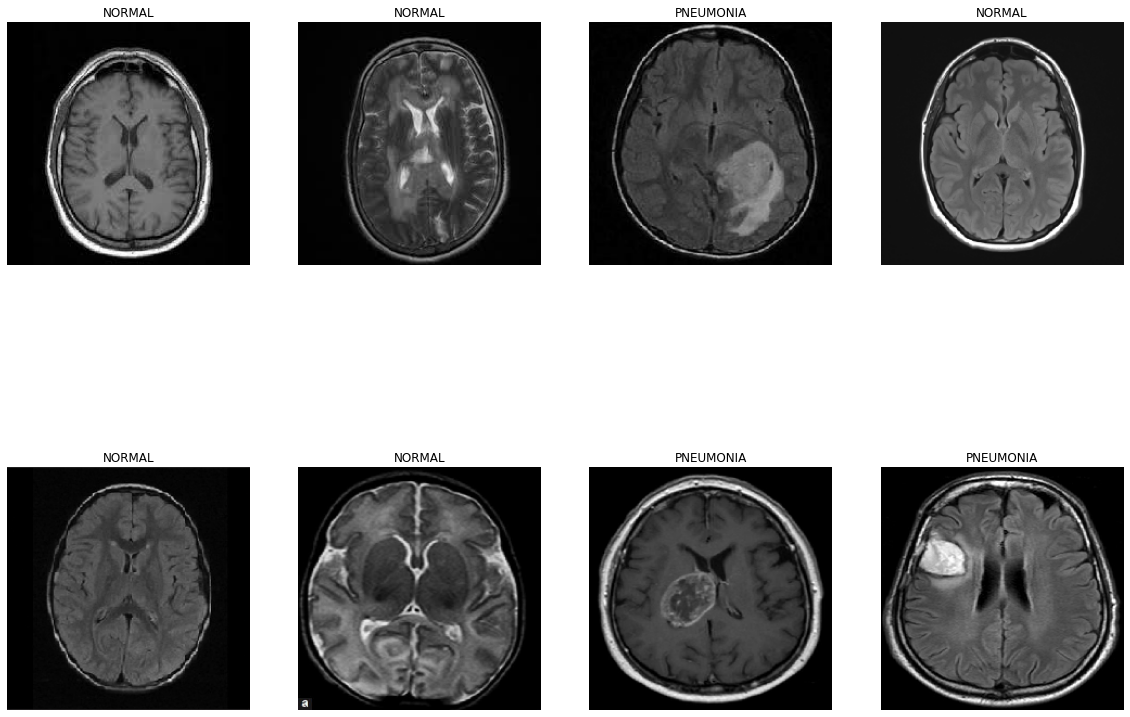

In [3]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title('PNEUMONIA' if img_label[i] == 1.0 else 'NORMAL')
        plt.axis("off")
        
    plt.show()
image_plot(train_ds,8)

## VGG19

In [76]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
#model_vgg19.add(tf.keras.layers.GlobalMaxPooling2D())
model_vgg19.add(tf.keras.layers.Flatten())
#model_vgg19.add(tf.keras.layers.Dropout(0.25))
#model_vgg19.add(tf.keras.layers.Dense(64, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dense(32, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dropout(0.1))

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [77]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 10.3128 - acc: 0.5172
Epoch 1: acc improved from -inf to 0.51724, saving model to model\vgg19_best.h5
4/4 [==============================] - 22s 5s/step - loss: 10.3128 - acc: 0.5172 - val_loss: 9.1239 - val_acc: 0.6200
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 6.9875 - acc: 0.6207
Epoch 2: acc improved from 0.51724 to 0.62069, saving model to model\vgg19_best.h5
4/4 [==============================] - 19s 5s/step - loss: 6.9875 - acc: 0.6207 - val_loss: 1.3472 - val_acc: 0.8000
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 3.1846 - acc: 0.6256
Epoch 3: acc improved from 0.62069 to 0.62562, saving model to model\vgg19_best.h5
4/4 [==============================] - 20s 5s/step - loss: 3.1846 - acc: 0.6256 - val_loss: 1.7470 - val_acc: 0.7800
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 1.8296 - acc: 0.8128
Epoch 4: acc improved from 0.62562 to 0.81281, saving

In [78]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 4s 4s/step - loss: 1.0615 - acc: 0.8200


,Train,Val
Loss,0.071052,1.061467
Acc,0.965517,0.820000


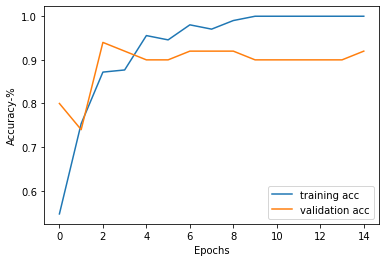

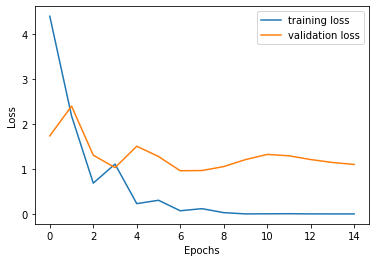

In [12]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

## Image Augmentation

In [7]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


## Plot image after image augmentation

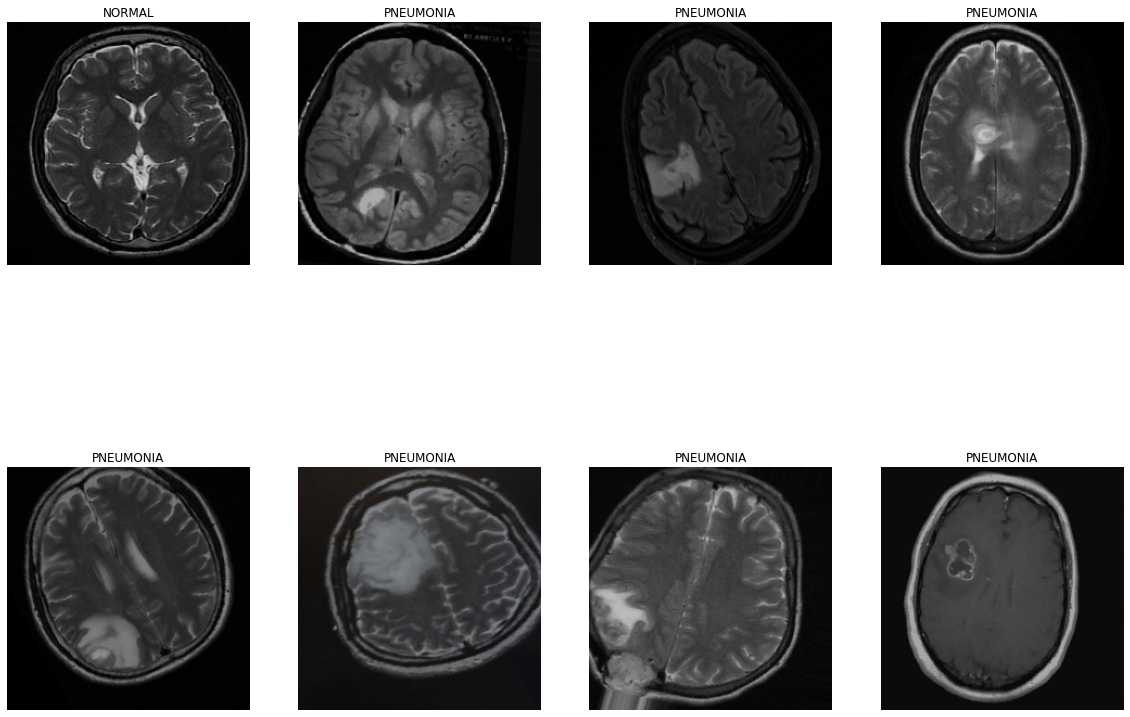

In [8]:
image_plot(aug_train_ds,8)

In [81]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.6854 - acc: 0.7945
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.6854 - acc: 0.7945 - val_loss: 0.5684 - val_acc: 0.8800 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.5784 - acc: 0.8735
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.5784 - acc: 0.8735 - val_loss: 0.2799 - val_acc: 0.9000 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.3388 - acc: 0.8775
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.3388 - acc: 0.8775 - val_loss: 0.2440 - val_acc: 0.9200 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.3726 - acc: 0.8656
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.3726 - acc: 0.8656 - val_loss: 0.

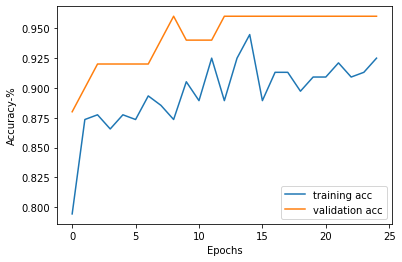

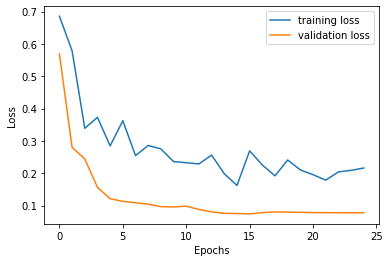

In [82]:
plot_learning_curve(history)

In [83]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

2/2 [==============================] - 4s 1s/step
[[18  1]
 [ 1 30]]

               precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.97      0.97      0.97        31

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [84]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 4s 4s/step - loss: 0.0774 - acc: 0.9600


,Train,Val
Loss,0.003139,0.077448
Acc,1.000000,0.960000


In [85]:
# total_false = np.where((ypred == ytest) == False)[0]
# fig, ax = plt.subplots(1, 5, figsize=(12, 6))
# ax = ax.ravel()
# for n,i in enumerate(total_false):
#     fig = plt.figure(figsize=(15,15))
#     plt.subplot(1,5,n+1)
    
#     image = plt.imshow(val_ds[0][0][i])
#     plt.show(image)
#     plt.title(f'real {int(ytest[i])}', c='red')

## Inception v3

In [35]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
#model_inceptionv3.add(tf.keras.layers.Dropout(0.2))
#model_inceptionv3.add(tf.keras.layers.Dense(8, activation='relu'))
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [36]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max",restore_best_weights=True, patience=10)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 8.1429 - acc: 0.5419WARNING:tensorflow:5 out of the last 25 calls to <function Model.make_test_function.<locals>.test_function at 0x0000024B4E779A60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 1: acc improved from -inf to 0.54187, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 15s 3s/step - loss: 8.1429 - acc: 0.5419 - val_loss: 4.2268 - val_acc: 0.4800
Epoch 2/25
4/

In [37]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 2s 2s/step - loss: 0.9638 - acc: 0.9600


,Train,Val
Loss,0.000276,0.963809
Acc,1.000000,0.960000


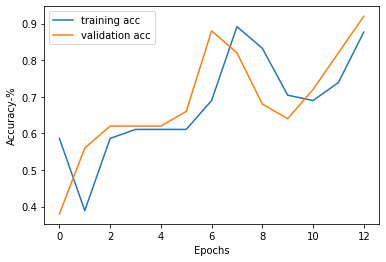

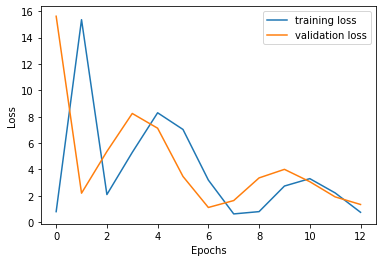

In [24]:
plot_learning_curve(history)

In [40]:
aug_train_ds = augmentataion_generator(height,width)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 1.7386 - acc: 0.8340
Epoch 1: acc improved from -inf to 0.83399, saving model to model\vgg19_best.h5
4/4 [==============================] - 13s 3s/step - loss: 1.7386 - acc: 0.8340 - val_loss: 2.9174 - val_acc: 0.7200 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 1.1674 - acc: 0.8419
Epoch 2: acc improved from 0.83399 to 0.84190, saving model to model\vgg19_best.h5
4/4 [==============================] - 13s 3s/step - loss: 1.1674 - acc: 0.8419 - val_loss: 0.6956 - val_acc: 0.9200 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 1.0809 - acc: 0.8775
Epoch 3: acc improved from 0.84190 to 0.87747, saving model to model\vgg19_best.h5
4/4 [==============================] - 12s 3s/step - loss: 1.0809 - acc: 0.8775 - val_loss: 0.7016 - val_acc: 0.8800 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - lo

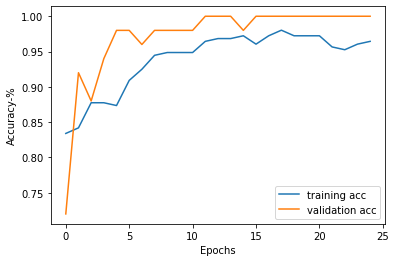

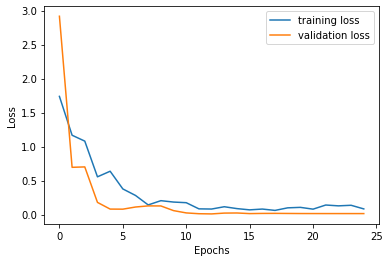

In [41]:
plot_learning_curve(history)

In [42]:
#height, width = 224, 224
datagen = ImageDataGenerator(
            rescale=1./255.,
            )
train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=253,
            #subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )

train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

Found 253 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step - loss: 0.0152 - acc: 1.0000


,Train,Val
Loss,0.00344,0.015161
Acc,1.00000,1.000000


In [44]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 4s 1s/step
Confusion_Matrix:
 [[19  0]
 [ 0 31]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

